In [5]:
import tensorflow.keras
from homemade_unet import unet_model_3d


In [6]:
input_shape = (1,64,64,64)
model = unet_model_3d(input_shape = input_shape, n_labels = 3)
#model.summary()

In [1]:
from data import get_balanced_train_and_validation_datasets

batch_size = 1
path_images = '/home/jaume/Documentos/DL_postgraduate/final_project/sample_data/imagesTr/'
path_labels = '/home/jaume/Documentos/DL_postgraduate/final_project/sample_data/labelsTr/'

train_dataset, validation_dataset, validation_images = get_balanced_train_and_validation_datasets(0.2,path_images,path_labels,patch_shape=(64,64,64),subsample=20,mask=True,repetitions=2)
train_dataset = train_dataset.batch(batch_size).prefetch(2)
validation_dataset = validation_dataset.batch(batch_size).prefetch(2)


Subsampling with images: ['pancreas_028.nii.gz', 'pancreas_050.nii.gz', 'pancreas_019.nii.gz', 'pancreas_006.nii.gz', 'pancreas_051.nii.gz', 'pancreas_049.nii.gz', 'pancreas_029.nii.gz', 'pancreas_018.nii.gz', 'pancreas_021.nii.gz', 'pancreas_048.nii.gz', 'pancreas_043.nii.gz', 'pancreas_012.nii.gz', 'pancreas_032.nii.gz', 'pancreas_001.nii.gz', 'pancreas_025.nii.gz', 'pancreas_035.nii.gz', 'pancreas_016.nii.gz', 'pancreas_040.nii.gz', 'pancreas_037.nii.gz', 'pancreas_046.nii.gz']
Number of images for training: 16
Number of images for validation: 4


In [2]:
validation_images

['pancreas_050.nii.gz',
 'pancreas_021.nii.gz',
 'pancreas_019.nii.gz',
 'pancreas_001.nii.gz']

In [2]:
for image in train_dataset:
    x,y = image
    print(x.shape)
    print(y.shape)
    break

Patches background: 57
Patches target: 3
Studying 6 patches for background and for target.
(1, 1, 64, 64, 64)
(1, 3, 64, 64, 64)


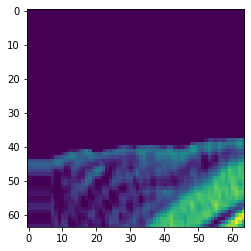

In [12]:
import pylab as plt

plt.imshow(x[0,0,:,:,50])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from datetime import datetime

time = datetime.now().strftime('%Y-%m-%d_%H-%M')

model_checkpoint = ModelCheckpoint(filepath='models/best/' + time + '_model_weights.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=10, 
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='runs/' + time,
                                   write_grads=True)

callbacks = [model_checkpoint,reduce_lr_plateau,tensorboard_callback]


In [ ]:
epochs = 80
model.fit(train_dataset,
          epochs=epochs,
          validation_data=validation_dataset,
          callbacks = callbacks)

In [ ]:
model.save_weights("models/final/" + time + "_model_weights.h5")